## WE11-Autoencoder Assignment 

### Created 5 28x28 pixel images of the first letter of my first name i.e. "A".

In [1]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np

# Define image dimensions
width = 28
height = 28

# Create a black background image
img = Image.new('L', (width, height), color=0)

# Define font and text
font = ImageFont.truetype("arial.ttf", 20)
text = "A"

# Create 5 versions of the letter with random offsets
for i in range(5):
    # Create a new blank image
    img_new = Image.new('L', (width, height), color=0)
    draw = ImageDraw.Draw(img_new)
    
    # Define random offsets for the letter
    offset_x = np.random.randint(0, 5)
    offset_y = np.random.randint(0, 5)
    
    # Draw the letter on the new image
    draw.text((offset_x, offset_y), text, font=font, fill=255)
    
    # Save the image
    img_new.save(f"{text}_{i}.png")


### Load and normalize the MNIST data

In [2]:
import numpy as np

In [3]:
from tensorflow.keras.datasets import mnist

# load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape)
print(test_images.shape)

# Flatten the images for a autoencoder input (28x28 is 784 -- therfore, input is 784 neurons)
train_images = np.reshape(train_images, (-1, 784))
test_images = np.reshape(test_images, (-1, 784))
print(train_images.shape)
print(test_images.shape)

# Normalize data - since it's grayscale, we can divide by 255 to get each pixel between 0 and 1
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

(60000, 28, 28)
(10000, 28, 28)
(60000, 784)
(10000, 784)


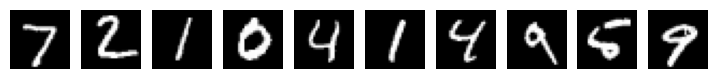

In [4]:
from matplotlib import pyplot as plt

n = 10
plt.figure(figsize=(9, 2))
for i in range(n):
  ax = plt.subplot(1, n, i+1)
  plt.imshow(test_images[i].reshape(28, 28), cmap="gray")
  ax.axis('off')

plt.show()

### Load our pretrained model and display the predictions for several random digits and then compare these to the original. 

In [5]:
from tensorflow import keras

pretrained_model = keras.models.load_model('initially_trained_autoencoder.h5')

313/313 [==============================] - 3s 8ms/step


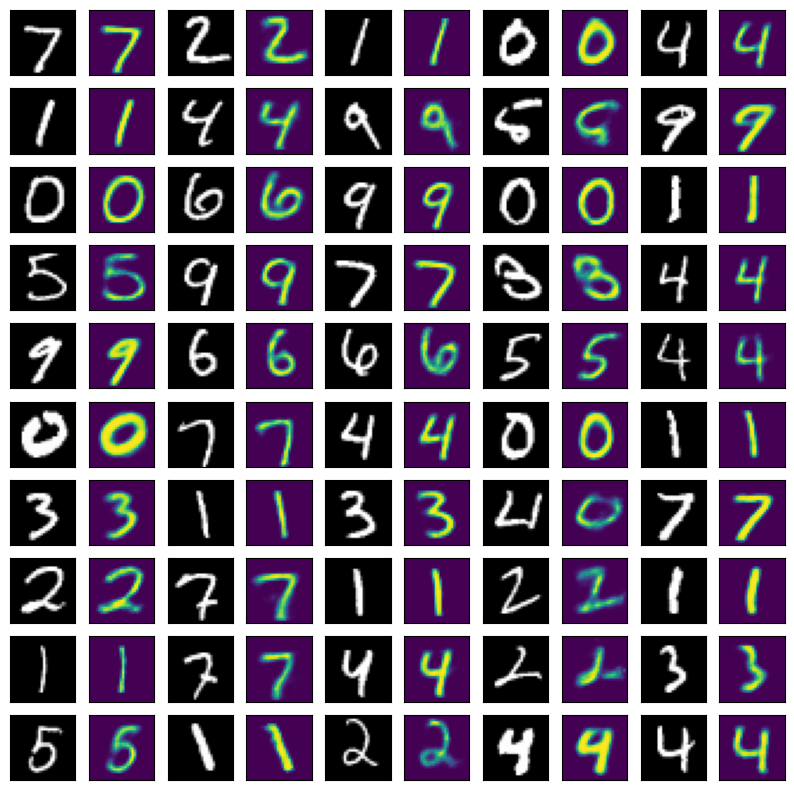

In [6]:
reconstructed_images = pretrained_model.predict(test_images)

images = []
for i in range(100):
    images.append(test_images[i].reshape(28,28))
    images.append(reconstructed_images[i].reshape(28,28))
rows = 10
cols = 10
plt.figure(figsize=(10,10))
for i in range(rows*cols):
    plt.subplot(rows,cols,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if (i%2 == 0):
        plt.imshow(images[i],cmap='gray')
    else:
        plt.imshow(images[i])
plt.show()

### Load our new character and test the autoencoder on this new symbol

1/1 [==============================] - 0s 40ms/step
(1, 784)


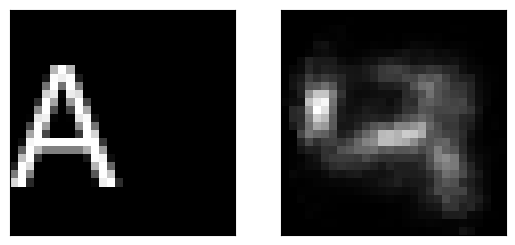

In [7]:
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image


####################################
# load a sample image
image = tf.keras.utils.load_img('A_0.png', target_size=(28, 28), color_mode = "grayscale")


####################################
# predict an image from this sample
input_arr = tf.keras.utils.img_to_array(image)
input_arr = input_arr/ 255 # normalize between 0 and 1
input_arr = input_arr.reshape(784)
input_arr = np.array([input_arr])  # Convert single image to a batch with one image in it

predictions = pretrained_model.predict(input_arr)
print(predictions.shape)


#####################################
# display the two images side by side
# 
plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(image, cmap="gray")


plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(predictions[0].reshape(28,28), cmap="gray")


plt.show()

The model has forgotten how to reconstruct, because the model was trained only on the MNIST digits and not on the dataset which included the new character images., and not the MNIST images.

#### Let's try to retrain the original model with a mix of the new characters and the original 10. Our goal it so avoid retraining with the entire original test test, and instead only use a small subset of the original test set.

In [8]:
from tensorflow.keras.datasets import mnist


# load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape)
print(test_images.shape)

# Flatten the images for a autoencoder input (28x28 is 784 -- therfore, input is 784 neurons)
train_images = np.reshape(train_images, (-1, 784))
test_images = np.reshape(test_images, (-1, 784))
print(train_images.shape)
print(test_images.shape)

# Normalize data - since it's grayscale, we can divide by 255 to get each pixel between 0 and 1
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

(60000, 28, 28)
(10000, 28, 28)
(60000, 784)
(10000, 784)


In [9]:
input_arr = input_arr.reshape(784)

np.random.shuffle(train_images)

bad_images = [input_arr for _ in range(135)]
new_image_set = np.vstack((train_images[:500], bad_images))
np.random.shuffle(new_image_set)

new_images_train = new_image_set[int(len(new_image_set)*.8):]
new_images_test = new_image_set[int(len(new_image_set)*.2):]
print(new_images_train.shape)
print(new_images_test.shape)

(127, 784)
(508, 784)


### Create a new autoencoder model.

In [10]:
from keras.layers import Input, Dense
from keras.models import Model

# Define input shape
input_shape = (784,)  # 28 x 28 = 784 pixels

# Define encoder architecture
input_img = Input(shape=input_shape)
encoded = Dense(32, activation='relu')(input_img)  # 32-dimensional latent space
encoder = Model(input_img, encoded)

# Define decoder architecture
latent_inputs = Input(shape=(32,))
decoded = Dense(784, activation='sigmoid')(latent_inputs)
decoder = Model(latent_inputs, decoded)

# Define autoencoder model
autoencoder = Model(input_img, decoder(encoded))

# Compile autoencoder model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')



# Train autoencoder model
autoencoder.fit(new_images_train, new_images_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(new_images_test, new_images_test))

# Use autoencoder for image compression
encoded_imgs = encoder.predict(new_images_test)
decoded_imgs = decoder.predict(encoded_imgs)


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6942 - val_loss: 0.6904
Epoch 2/10
1/1 [==============================] - 0s 73ms/step - loss: 0.6904 - val_loss: 0.6865
Epoch 3/10
1/1 [==============================] - 0s 73ms/step - loss: 0.6866 - val_loss: 0.6821
Epoch 4/10
1/1 [==============================] - 0s 76ms/step - loss: 0.6823 - val_loss: 0.6770
Epoch 5/10
1/1 [==============================] - 0s 72ms/step - loss: 0.6773 - val_loss: 0.6710
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 0.6713 - val_loss: 0.6640
Epoch 7/10
1/1 [==============================] - 0s 79ms/step - loss: 0.6644 - val_loss: 0.6558
Epoch 8/10
1/1 [==============================] - 0s 73ms/step - loss: 0.6563 - val_loss: 0.6464
Epoch 9/10
1/1 [==============================] - 0s 81ms/step - loss: 0.6470 - val_loss: 0.6359
Epoch 10/10
16/16 [==============================] - 0s 2ms/step


In [11]:
from tensorflow import keras
updated_model = keras.models.load_model('initially_trained_autoencoder.h5')

from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training

# Train the autoencoder with MNIST data
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)
history = updated_model.fit(
    x=new_images_train, # For autoencoders, both the input and the target are the same
    y=new_images_train, 
    epochs=15, 
    batch_size=128,
    shuffle=True, 
    validation_data=(new_images_test, new_images_test),
    callbacks=[early_stop]
)

Epoch 1/15
1/1 [==============================] - 2s 2s/step - loss: 0.1374 - val_loss: 0.1347
Epoch 2/15
1/1 [==============================] - 0s 150ms/step - loss: 0.1317 - val_loss: 0.1310
Epoch 3/15
1/1 [==============================] - 0s 138ms/step - loss: 0.1272 - val_loss: 0.1275
Epoch 4/15
1/1 [==============================] - 0s 166ms/step - loss: 0.1229 - val_loss: 0.1219
Epoch 5/15
1/1 [==============================] - 0s 157ms/step - loss: 0.1162 - val_loss: 0.1171
Epoch 6/15
1/1 [==============================] - 0s 152ms/step - loss: 0.1102 - val_loss: 0.1125
Epoch 7/15
1/1 [==============================] - 0s 155ms/step - loss: 0.1047 - val_loss: 0.1081
Epoch 8/15
1/1 [==============================] - 0s 173ms/step - loss: 0.0993 - val_loss: 0.1053
Epoch 9/15
1/1 [==============================] - 0s 165ms/step - loss: 0.0955 - val_loss: 0.1022
Epoch 10/15
1/1 [==============================] - 0s 156ms/step - loss: 0.0910 - val_loss: 0.1009
Epoch 11/15
1/1 [=====

(508, 784)
16/16 [==============================] - 0s 9ms/step


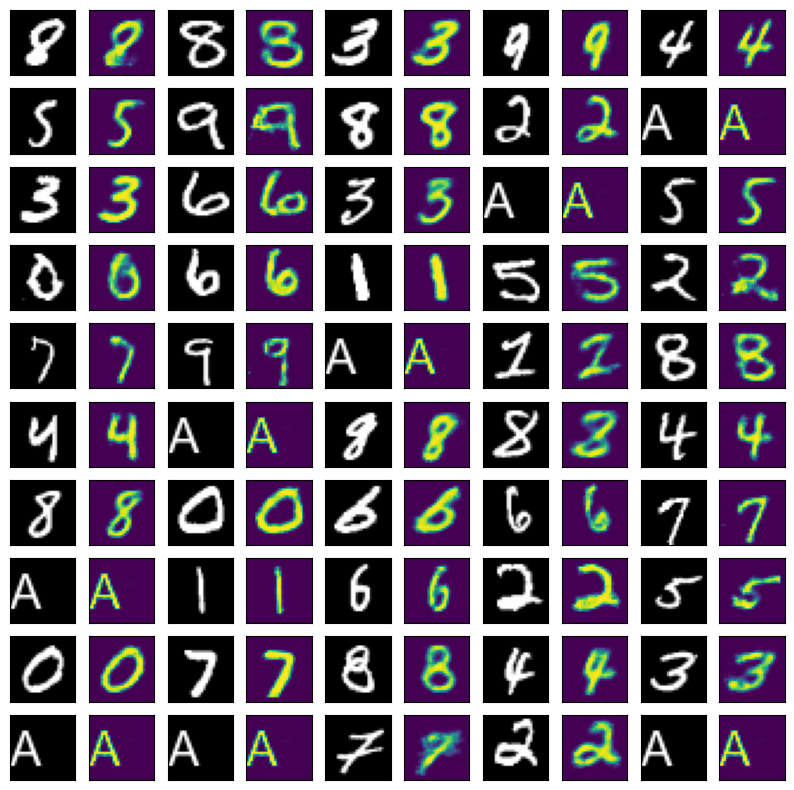

In [12]:
print(new_images_test.shape)
reconstructed_images = updated_model.predict(new_images_test)

images = []
for i in range(100):
    images.append(new_images_test[i].reshape(28,28))
    images.append(reconstructed_images[i].reshape(28,28))
rows = 10
cols = 10
plt.figure(figsize=(10,10))
for i in range(rows*cols):
    plt.subplot(rows,cols,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if (i%2 == 0):
        plt.imshow(images[i],cmap='gray')
    else:
        plt.imshow(images[i])
plt.show()

### Here, we can see the original and the reconstructed images of the whole MNIST dataset, which includes a random set of digits and also the new character. Also here i have loaded the initially trained autoencoder and then trained the model on our new dataset and obtained the output.